In [1]:
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from gpflow.ci_utils import ci_niter

plt.rcParams["figure.figsize"] = (12, 6)
np.random.seed(123)

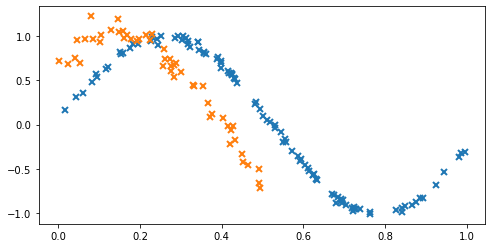

In [2]:
# make a dataset with two outputs, correlated, heavy-tail noise. One has more noise than the other.
X1 = np.random.rand(100, 1)  # Observed locations for first output
X2 = np.random.rand(50, 1) * 0.5  # Observed locations for second output

Y1 = np.sin(6 * X1) + np.random.randn(*X1.shape) * 0.03
Y2 = np.sin(6 * X2 + 0.7) + np.random.randn(*X2.shape) * 0.1

plt.figure(figsize=(8, 4))
plt.plot(X1, Y1, "x", mew=2)
_ = plt.plot(X2, Y2, "x", mew=2)

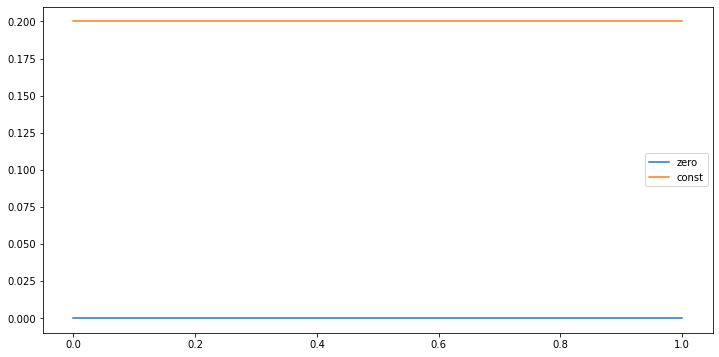

In [10]:

from gpflow.mean_functions import Zero, Constant


X = np.linspace(0,1,100).reshape(-1,1)
mean_fn = Zero()
plt.plot(X, mean_fn(X), label='zero')
mean_fn = Constant()
mean_fn.c = .2
plt.plot(X, mean_fn(X), label='const')

plt.legend()


In [ ]:
X_augmented = np.vstack((np.hstack((X1, np.zeros_like(X1))), np.hstack((X2, np.ones_like(X2)))))

# Augment the Y data with ones or zeros that specify a likelihood from the list of likelihoods
Y_augmented = np.vstack((np.hstack((Y1, np.zeros_like(Y1))), np.hstack((Y2, np.ones_like(Y2)))))

In [ ]:
output_dim = 2  # Number of outputs
rank = 1  # Rank of W

# Base kernel
k = gpflow.kernels.Matern32(active_dims=[0])
k = gpflow.kernels.SquaredExponential(active_dims=[0])


# Coregion kernel
coreg = gpflow.kernels.Coregion(output_dim=output_dim, rank=rank, active_dims=[1])

kern = k * coreg

In [ ]:
# This likelihood switches between Gaussian noise with different variances for each f_i:
lik = gpflow.likelihoods.SwitchedLikelihood(
    [gpflow.likelihoods.Gaussian(), gpflow.likelihoods.Gaussian()]
)

# now build the GP model as normal
m = gpflow.models.VGP((X_augmented, Y_augmented), kernel=kern, likelihood=lik)

# fit the covariance function parameters
maxiter = ci_niter(10000)
gpflow.optimizers.Scipy().minimize(
    m.training_loss, m.trainable_variables, options=dict(maxiter=maxiter), method="L-BFGS-B",
)

In [ ]:
def plot_gp(x, mu, var, color, label):
    plt.plot(x, mu, color=color, lw=2, label=label)
    plt.fill_between(
        x[:, 0],
        (mu - 2 * np.sqrt(var))[:, 0],
        (mu + 2 * np.sqrt(var))[:, 0],
        color=color,
        alpha=0.4,
    )


def plot(m):
    plt.figure(figsize=(8, 4))
    Xtest = np.linspace(0, 1, 100)[:, None]
    (line,) = plt.plot(X1, Y1, "x", mew=2)
    mu, var = m.predict_f(np.hstack((Xtest, np.zeros_like(Xtest))))
    plot_gp(Xtest, mu, var, line.get_color(), "Y1")

    (line,) = plt.plot(X2, Y2, "x", mew=2)
    mu, var = m.predict_f(np.hstack((Xtest, np.ones_like(Xtest))))
    plot_gp(Xtest, mu, var, line.get_color(), "Y2")

    plt.legend()


plot(m)

In [ ]:
B = coreg.output_covariance().numpy()
print("B =", B)
_ = plt.imshow(B)